In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import os
import matplotlib.pyplot as plt
from networkx.algorithms.community import greedy_modularity_communities
from networkx.algorithms import bipartite
import igraph as ig
import leidenalg as la
from itertools import combinations
from scipy.stats import zscore

# Flash Assignment 2
Emil Künstner, Xun Li

## 1. EDA

In [2]:
# Load the dataset
youtube_data = pd.read_csv("youtube_cross_platform.csv")

twitter_data = pd.read_csv("twitter_cross_platform.csv")
facebook_data = pd.read_csv("facebook_cross_platform.csv")
reddit_data = pd.read_csv("reddit_cross_platform.csv")

for df in [youtube_data, twitter_data, facebook_data, reddit_data]:
    df['nodeTime'] = pd.to_datetime(df['nodeTime'])

all_data = pd.concat([youtube_data, twitter_data, facebook_data, reddit_data], ignore_index=True)
data = pd.concat([twitter_data, facebook_data, reddit_data], ignore_index=True)

twitter_data['nodeTime'] = pd.to_datetime(twitter_data['nodeTime'])

twitter_data = twitter_data[['nodeUserID', 'videoID', 'nodeTime']]

In [26]:
data.head()

,nodeID,nodeUserID,nodeTime,actionType,videoID,platform
0,NRFEnex8MF21dytDg9vfAg,ff0vicGZco1mZzYxUCWiGg,2018-04-01 02:13:00,tweet,6h0VDhENotI,twitter
1,Qeyxwl00d0vgLfKh1YqUEw,MCUuXxcepDc2FFRh9i-AtQ,2018-04-01 03:34:41,tweet,NQL3rX6xWRg,twitter
2,1QIQqg23ItMfiKbFFrPkAw,5hBVs8jS6_vCAFsHOjvKcA,2018-04-01 10:23:20,tweet,VLMOHhKkrX8,twitter
3,iYMBH3KdJvOiUHYxeKfx_w,qhQLCsDQNEtptuJJzfEVZA,2018-04-01 11:13:02,tweet,VLMOHhKkrX8,twitter
4,G86DyDFas0zLKkBFW0GWwg,lSmQYvUcuGn6oFyjGJduDw,2018-04-01 13:43:07,tweet,4oQTWn1JfeA,twitter


In [4]:
result = []
for video_id, group in data.groupby('videoID'):
    # Generate all combinations of users who share the same videoID
    user_combinations = list(combinations(group.iterrows(), 2))
    for (idx_1, row_1), (idx_2, row_2) in user_combinations:
        time_diff = abs((row_1['nodeTime'] - row_2['nodeTime']).total_seconds())
        result.append({
            'videoID': video_id,
            'userID_1': row_1['nodeUserID'],
            'userID_2': row_2['nodeUserID'],
            'timestamp_1': row_1['nodeTime'],
            'timestamp_2': row_2['nodeTime'],
            'time_diff_seconds': time_diff,
            'user_1_platform': row_1['platform'],
            'user_2_platform': row_2['platform']
        })

# Convert result to a DataFrame
result_df = pd.DataFrame(result)

In [28]:
result_df.head()

,videoID,userID_1,userID_2,timestamp_1,timestamp_2,time_diff_seconds,user_1_platform,user_2_platform
0,-6bGXfM8-gs,7t2ODJ3-kpQg6aoxnCjQeQ,19372991,2018-07-27 23:00:51,2018-07-22 21:19:58,438053.0,twitter,facebook
1,-6bGXfM8-gs,7t2ODJ3-kpQg6aoxnCjQeQ,elboydo,2018-07-27 23:00:51,2018-07-23 16:02:07,370724.0,twitter,reddit
2,-6bGXfM8-gs,7t2ODJ3-kpQg6aoxnCjQeQ,elboydo,2018-07-27 23:00:51,2018-07-24 18:07:07,276824.0,twitter,reddit
3,-6bGXfM8-gs,19372991,elboydo,2018-07-22 21:19:58,2018-07-23 16:02:07,67329.0,facebook,reddit
4,-6bGXfM8-gs,19372991,elboydo,2018-07-22 21:19:58,2018-07-24 18:07:07,161229.0,facebook,reddit


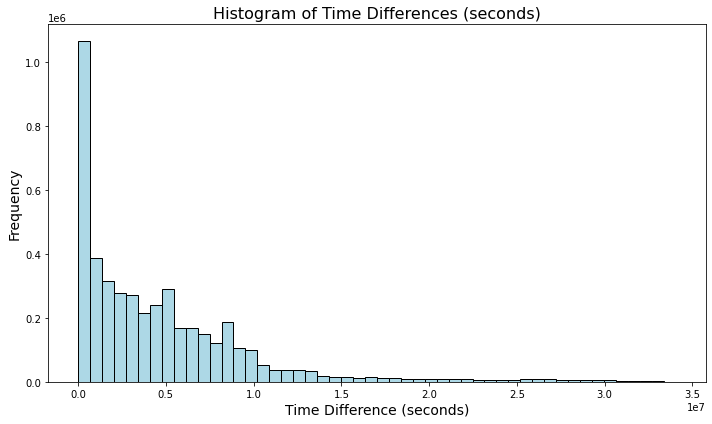

In [9]:
plt.figure(figsize=(10, 6))
plt.hist(result_df['time_diff_seconds'], bins=50, color='lightblue', edgecolor='black')

plt.title('Histogram of Time Differences (seconds)', fontsize=16)
plt.xlabel('Time Difference (seconds)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.tight_layout()
plt.show()

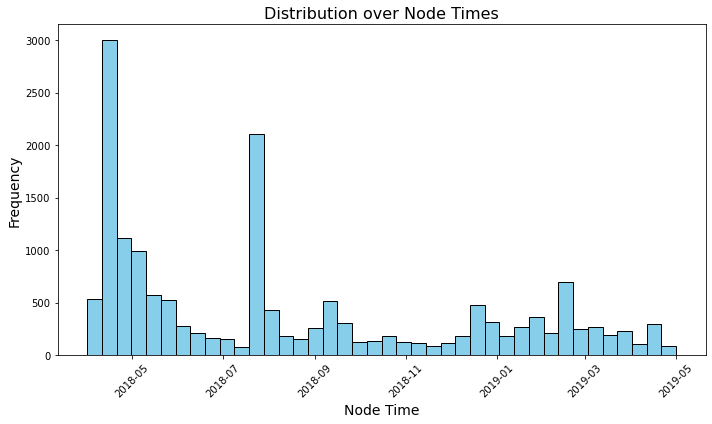

In [30]:
# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(data['nodeTime'], bins=40, color='skyblue', edgecolor='black')

plt.title('Distribution over Node Times', fontsize=16)
plt.xlabel('Node Time', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## 2. Build a bipart graph. Find the largest connected group. Get it projection on user only.

In [31]:
G = nx.Graph()

# Add nodes and edges
for _, row in twitter_data.iterrows():
    user = row['nodeUserID']
    video = row['videoID']
    
    G.add_node(user, bipartite=0)  # Users
    G.add_node(video, bipartite=1)  # Videos
    
    G.add_edge(user, video)

# Find the largest connected component
largest_cc = max(nx.connected_components(G), key=len)

# Create a subgraph with the largest connected component
G_largest = G.subgraph(largest_cc).copy()


In [32]:
# Check connected components
components = list(nx.connected_components(G))
print(f"Number of connected components: {len(components)}")

# Largest connected component
largest_component = max(components, key=len)
print(f"Size of the largest component: {len(largest_component)}")



Number of connected components: 116
Size of the largest component: 5235


### Visualization of the bipart graph.

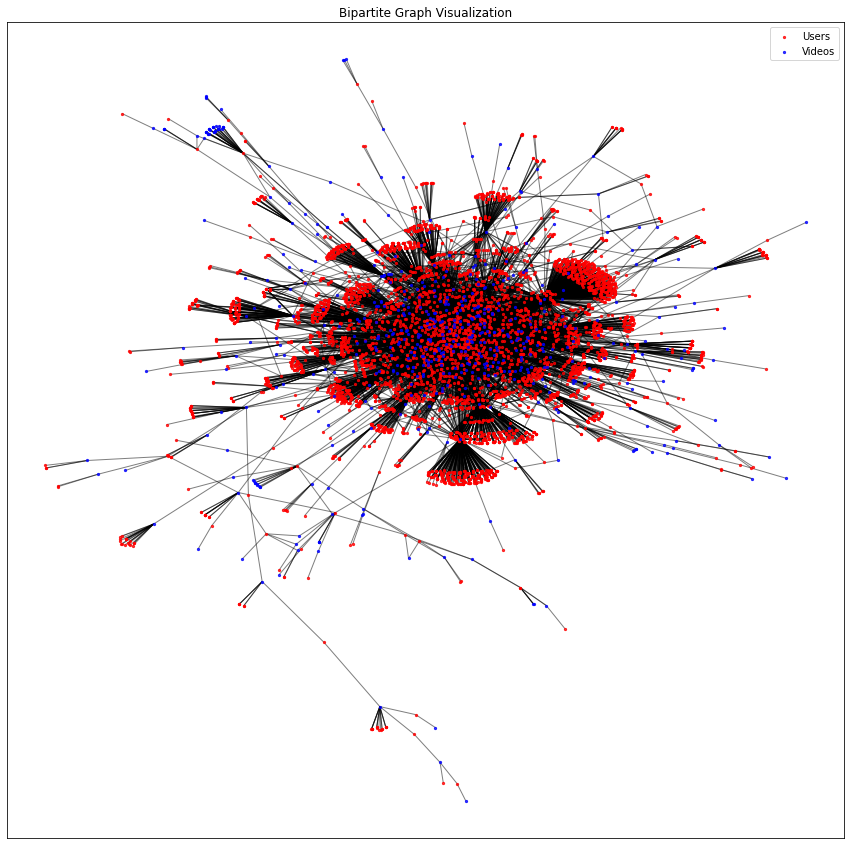

In [33]:
# Visualize the Graph
plt.figure(figsize=(15, 15))  # Set the figure size (width, height) in inches
pos = nx.spring_layout(G_largest)  # positions for all nodes

# Separate the nodes by bipartite set
users = {n for n, d in G_largest.nodes(data=True) if d['bipartite'] == 0}
videos = set(G_largest) - users

nx.draw_networkx_nodes(G_largest, pos, nodelist=users, node_color='r', node_size=5, alpha=0.8, label='Users')
nx.draw_networkx_nodes(G_largest, pos, nodelist=videos, node_color='b', node_size=5, alpha=0.8, label='Videos')

nx.draw_networkx_edges(G_largest, pos, width=1.0, alpha=0.5)
plt.legend(scatterpoints=1)
plt.title('Bipartite Graph Visualization')
plt.show()

Get the user-only projection graph, with weighted edges. The weights are the number of shared videos between users.

In [34]:
user_projection = bipartite.weighted_projected_graph(G_largest, users)

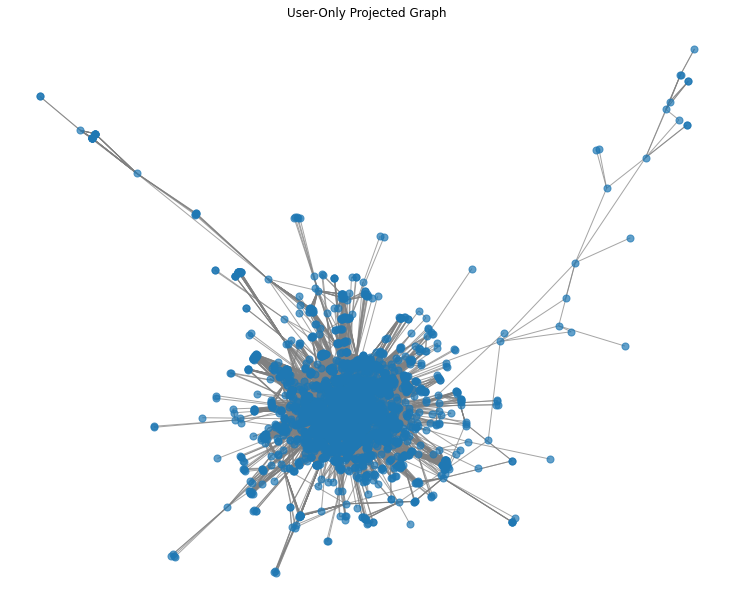

In [35]:
# Draw the user-only graph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(user_projection)
nx.draw(
    user_projection,
    pos=pos,
    with_labels=False,
    node_size=50,
    edge_color="gray",
    alpha=0.7
)

plt.title("User-Only Projected Graph")
plt.show()

## 3. Find communities.

Try Greedy modularity algorithm to detect the communities.

In [36]:
communities = greedy_modularity_communities(user_projection)

# Print communities
for i, community in enumerate(communities):
    print(f"Community {i+1}: {len(community)} users")

Community 1: 1903 users
Community 2: 873 users
Community 3: 601 users
Community 4: 302 users
Community 5: 302 users
Community 6: 237 users
Community 7: 199 users
Community 8: 48 users
Community 9: 45 users
Community 10: 45 users
Community 11: 25 users
Community 12: 19 users
Community 13: 19 users
Community 14: 17 users
Community 15: 13 users
Community 16: 12 users
Community 17: 10 users
Community 18: 9 users
Community 19: 8 users
Community 20: 5 users
Community 21: 4 users
Community 22: 4 users
Community 23: 4 users


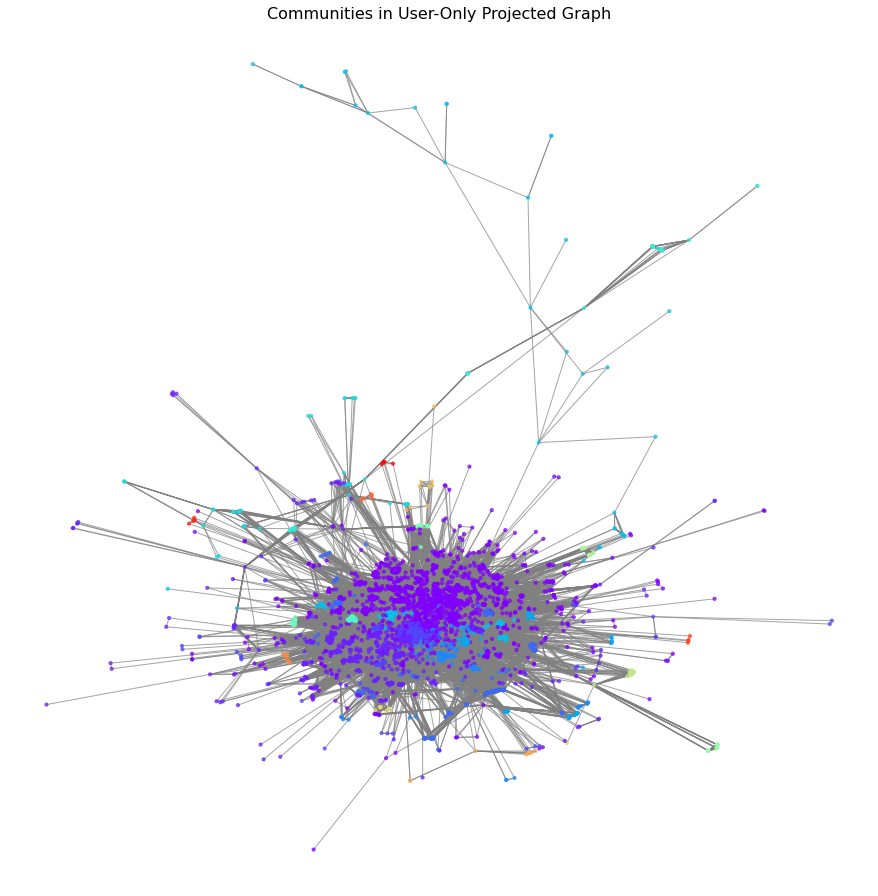

In [37]:
node_community_map = {}
for i, community in enumerate(communities):
    for node in community:
        node_community_map[node] = i
# Assign a color to each community
colors = [node_community_map[node] for node in user_projection.nodes]

# Visualize the graph with communities
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(user_projection)  # Layout for positioning nodes
nx.draw(
    user_projection,
    pos,
    with_labels=False,
    node_color=colors,
    node_size=10,
    cmap=plt.cm.rainbow,  # Use a colormap for community colors
    edge_color="gray",
    alpha=0.7
)
plt.title("Communities in User-Only Projected Graph", fontsize=16)
plt.show()

Try Leiden Algorithm

Why Choose Leiden Algorithm?

Improved Modularity: Achieves better optimization than Louvain.

Stable Communities: Produces consistent and meaningful results.

Handles Edge Weights: Takes weights into account when clustering.

Scalable: Can handle large graphs efficiently.


In [38]:
# Convert NetworkX graph to iGraph
user_projection_igraph = ig.Graph.TupleList(user_projection.edges(data=True), directed=False)

# Add weights
weights = [data["weight"] if "weight" in data else 1 for _, _, data in user_projection.edges(data=True)]
user_projection_igraph.es["weight"] = weights

In [39]:
partition = la.find_partition(
    user_projection_igraph, la.ModularityVertexPartition, weights="weight"
)

# Get communities
communities = [community for community in partition]
print(f"Number of communities detected: {len(communities)}")

node_community_map = {}
for community_id, community in enumerate(communities):
    for node in community:
        node_community_map[user_projection_igraph.vs[node]["name"]] = community_id

Number of communities detected: 19


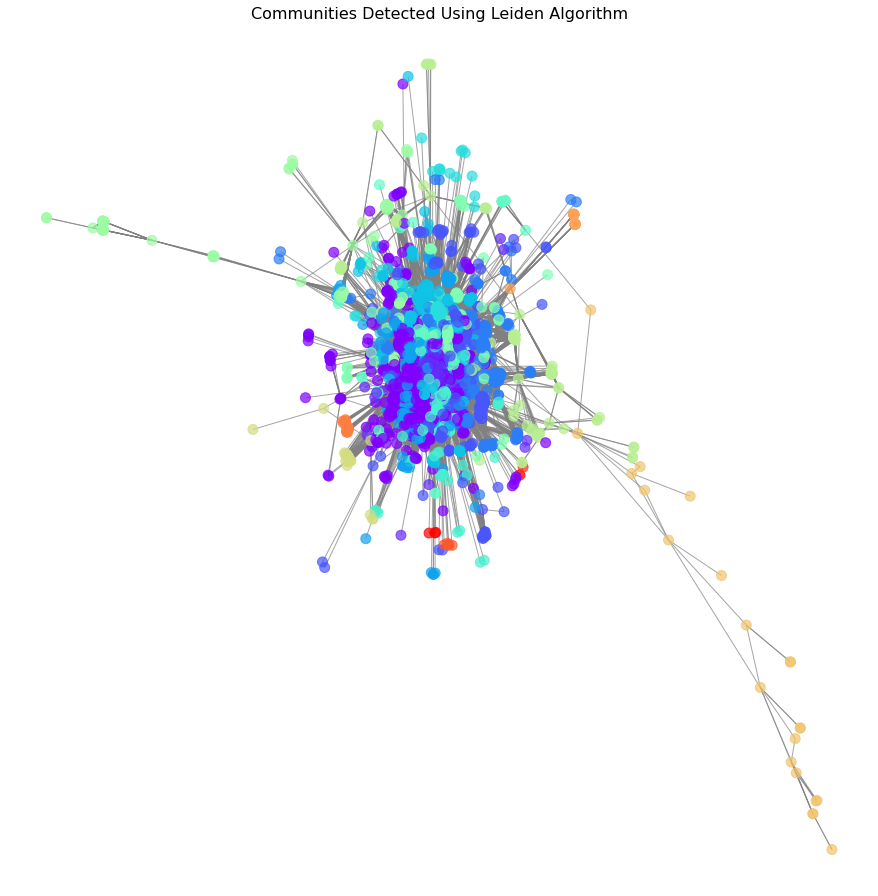

In [40]:
# Assign a color to each community
colors = [node_community_map[node] for node in user_projection.nodes()]

# Visualize the graph with communities
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(user_projection)  # Layout for positioning nodes
nx.draw(
    user_projection,
    pos,
    with_labels=False,
    node_color=colors,
    node_size=100,
    cmap=plt.cm.rainbow,
    edge_color="gray",
    alpha=0.7
)
plt.title("Communities Detected Using Leiden Algorithm", fontsize=16)
plt.show()

In [41]:
# Reconstruct communities
communities = {i: [] for i in set(node_community_map.values())}
for node, comm in node_community_map.items():
    communities[comm].append(node)

# Check density
for comm_id, nodes in communities.items():
    subgraph = user_projection.subgraph(nodes)
    density = nx.density(subgraph)
    print(f"Community {comm_id}: {len(nodes)} nodes, {subgraph.number_of_edges()} edges, Density: {density}")

Community 0: 1101 nodes, 42378 edges, Density: 0.06998266039137974
Community 1: 633 nodes, 191929 edges, Density: 0.9595106685064091
Community 2: 465 nodes, 9086 edges, Density: 0.08422321097515759
Community 3: 448 nodes, 13088 edges, Density: 0.13071268775966763
Community 4: 377 nodes, 26849 edges, Density: 0.37881652463457305
Community 5: 358 nodes, 11436 edges, Density: 0.17895873433172152
Community 6: 323 nodes, 44039 edges, Density: 0.8468549891352422
Community 7: 288 nodes, 13266 edges, Density: 0.320993031358885
Community 8: 226 nodes, 11462 edges, Density: 0.4508161258603737
Community 9: 195 nodes, 7606 edges, Density: 0.4021147237642083
Community 10: 102 nodes, 817 edges, Density: 0.15860997864492332
Community 11: 94 nodes, 534 edges, Density: 0.12216884008236102
Community 12: 24 nodes, 179 edges, Density: 0.6485507246376812
Community 13: 22 nodes, 34 edges, Density: 0.1471861471861472
Community 14: 20 nodes, 190 edges, Density: 1.0
Community 15: 17 nodes, 136 edges, Density: 

The Leiden Algorithm finds 18 communities while greedy modularity algorithm finds 25. 

We also calculate the density of each community from the Leiden Algorithm.

#### Using Z-Scores

In the following code we used Z-Scores to identify suspicious time differences between sharing of Videos.

In [15]:
from kneed import KneeLocator

In [ ]:
grouped = result_df.groupby('videoID')

for video, group in grouped:
    print(f"Video ID: {video}")
    print(group[['userID_1', 'userID_2', 'time_diff_seconds']])
    
    # Calculate Z-scores
    group['z_score'] = zscore(group['time_diff_seconds'])
    
    # Z-score > 2
    suspicious = group[group['z_score'] > 2]
    print("Suspicious activity:")
    print(suspicious)

result_df['z_score'] = result_df.groupby('videoID')['time_diff_seconds'].transform(zscore)
suspicious_df = result_df[result_df['z_score'] > 2]

Video ID: -6bGXfM8-gs
                 userID_1  userID_2  time_diff_seconds
0  7t2ODJ3-kpQg6aoxnCjQeQ  19372991           438053.0
1  7t2ODJ3-kpQg6aoxnCjQeQ   elboydo           370724.0
2  7t2ODJ3-kpQg6aoxnCjQeQ   elboydo           276824.0
3                19372991   elboydo            67329.0
4                19372991   elboydo           161229.0
5                 elboydo   elboydo            93900.0
Suspicious activity:
Empty DataFrame
Columns: [videoID, userID_1, userID_2, timestamp_1, timestamp_2, time_diff_seconds, user_1_platform, user_2_platform, z_score]
Index: []
Video ID: -AhzCC-UWn8
                  userID_1                userID_2  time_diff_seconds
6   LxAhk81P6vWzHnJ8PjBF6Q  RX0Kd7uXXfD-dUwhuaxfsQ            12854.0
7   LxAhk81P6vWzHnJ8PjBF6Q  0LvVa-AjQfKIGl9OZVf-rg            17190.0
8   LxAhk81P6vWzHnJ8PjBF6Q  kgJqQuQHWzUcmkDZ2IGCwg           211250.0
9   LxAhk81P6vWzHnJ8PjBF6Q  ETMksa_14wkAU9jh_sExXg           215423.0
10  RX0Kd7uXXfD-dUwhuaxfsQ  0LvVa-AjQfKIGl9OZVf

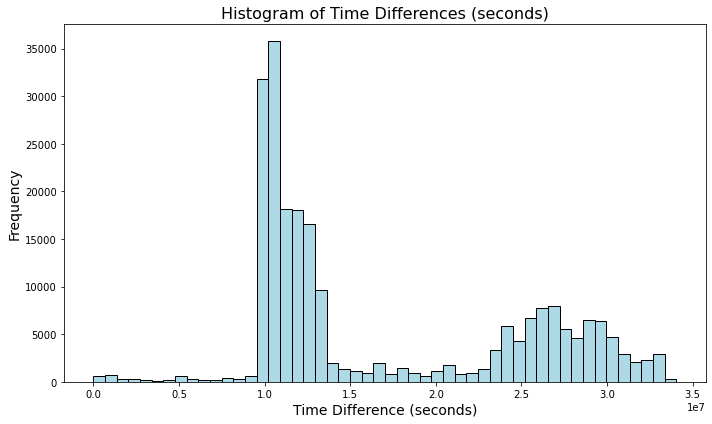

In [12]:
plt.figure(figsize=(10, 6))
plt.hist(suspicious_df['time_diff_seconds'], bins=50, color='lightblue', edgecolor='black')

# Formatting the plot
plt.title('Histogram of Time Differences (seconds)', fontsize=16)
plt.xlabel('Time Difference (seconds)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()

For this technique we computed the Z-Score for all instances and eliminated supicious instances with a Z-Score of bigger then 2. The problem of this method is that most times were close to zero seconds. Because of this the Z-Score method failed to identify small values as suspicious.

#### Knee

In this approach we assume that the frequency of sharings of a Video significantly dropps of after the time bots and other organized posters usually take to post. The hope is that we can identify a bend, elbow or knee in the histogram of the time differences.

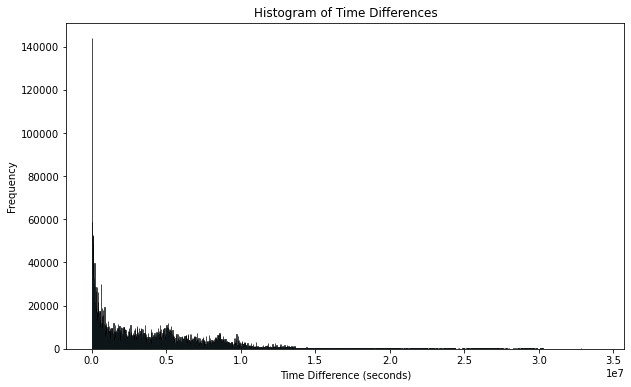

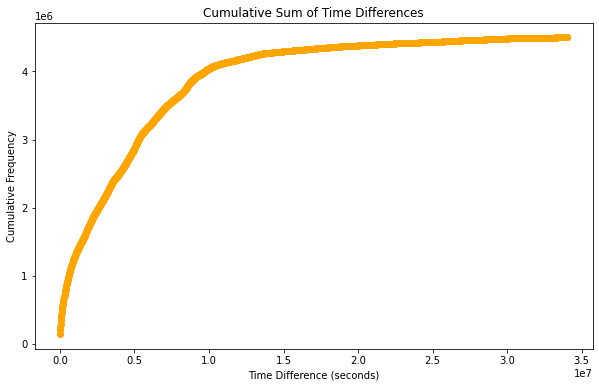

In [19]:
time_differences = result_df['time_diff_seconds']

# Create a histogram
plt.figure(figsize=(10, 6))
counts, bins, _ = plt.hist(time_differences, bins=2000, color='skyblue', alpha=0.7, edgecolor='black')
plt.title("Histogram of Time Differences")
plt.xlabel("Time Difference (seconds)")
plt.ylabel("Frequency")
plt.show()

# Compute cumulative sum
cumulative_sum = np.cumsum(counts)
plt.figure(figsize=(10, 6))
plt.plot(bins[:-1], cumulative_sum, marker='o', color='orange')
plt.title("Cumulative Sum of Time Differences")
plt.xlabel("Time Difference (seconds)")
plt.ylabel("Cumulative Frequency")
plt.show()

Flattening point detected at: 34030414.281 seconds


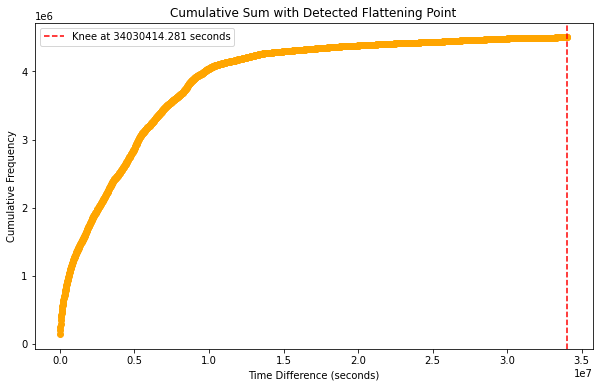

In [20]:
knee = KneeLocator(bins[:-1], cumulative_sum, curve="convex", direction="increasing")

print(f"Flattening point detected at: {knee.knee} seconds")

# Plot cumulative sum with knee point
plt.figure(figsize=(10, 6))
plt.plot(bins[:-1], cumulative_sum, marker='o', color='orange')
plt.axvline(x=knee.knee, color='red', linestyle='--', label=f"Knee at {knee.knee} seconds")
plt.title("Cumulative Sum with Detected Flattening Point")
plt.xlabel("Time Difference (seconds)")
plt.ylabel("Cumulative Frequency")
plt.legend()
plt.show()

As it can be seen in the plot above the algorithm fails to detect a significant bend but instead takes the last point. Even though one could see a bend at 1e7 seconds. But even if we take this result this would be way off the in the previous work discovered 52 seconds and with that no satisfiing result.

## Discussion

From the density of each group, we can easily noticed that there are big communities with significantly high density, which are not normal in organic behaviours, especially for large group. Community 2 and Community 5 has 0.96 and 0.82 density respectively. Regarding group with less nodes, for example comminity 16, 17 and 18, the 1 density could be explained that the same entity is managing several accounts, which is normal. 